# Insights from City Supply and Demand Data
Source: https://platform.stratascratch.com/data-projects/insights-city-supply-and-demand-data

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [113]:
sd = pd.read_csv("./datasets/dataset_1.csv")

### (1) Data manipulation

In [155]:
# Fix column names
sd.columns = [c.strip().replace(" ", "_") for c in sd.columns]
sd = sd.rename({"Time_(Local)": "Time"}, axis=1)
sd["Date"] = sd.Date.ffill()

sd = sd.assign(
    datets=lambda x: pd.to_datetime(x.Date, format="%d-%b-%y"),
    Weekday=lambda x: x.datets.dt.weekday,
    Weekend=lambda x: np.where(
        (
            ((x.Weekday == 4) & (x.Time >= 17))
            | (x.Weekday == 5)
            | ((x.Weekday == 6) & (x.Time <= 3))
        ),
        1,
        0,
    ),
    request_past8hr=lambda x: x.Requests.rolling(8).sum(),
    zeroes_past72hr=lambda x: x.Zeroes.rolling(72).sum(),
    eyeballs_past72hr=lambda x: x.Eyeballs.rolling(72).sum(),
    zero_to_eye_p72=lambda x: x.zeroes_past72hr / x.eyeballs_past72hr,
)

sd = sd.sort_values(["Date", "Time"])

### (2) Questions

#### 1. Which date had the most completed trips during the two week period?

In [115]:
sd.groupby("Date", as_index=False)["Completed_Trips"].sum().nlargest(
    1, "Completed_Trips", keep="all"
)


,Date,Completed_Trips
12,22-Sep-12,248


#### 2. What was the highest number of completed trips within a 24 hour period?

In [116]:
sd.nlargest(1, "Completed_Trips", keep="all")[["Date", "Time", "Completed_Trips"]]

,Date,Time,Completed_Trips
280,21-Sep-12,23,36


#### 3. Which hour of the day had the most requests during the two week period?

In [117]:
sd.groupby("Time", as_index=False).Requests.sum().nlargest(1, "Requests", keep="all")

,Time,Requests
23,23,184


#### 4.What percentages of all zeroes during the two week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)? Tip: The local time value is the start of the hour (e.g. 15 is the hour from 3:00pm - 4:00pm)

In [118]:
sd.query("Weekend == 1").Zeroes.sum() / sd.Zeroes.sum() * 100

45.066480055983206

#### 5. What is the weighted average ratio of completed trips per driver during the two week period? Tip: "Weighted average" means your answer should account for the total trip volume in each hour to determine the most accurate number in whole period.

In [119]:
sd.Completed_Trips.sum() / sd.Unique_Drivers.sum()

0.5145118733509235

#### 6. In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests? A new shift starts in every 8 hours. Assume that a driver will work same shift each day.

In [120]:
hr = (
    sd.groupby("Time", as_index=False)
    .request_past8hr.sum()
    .nlargest(1, "request_past8hr")
    .iloc[0]["Time"]
    .astype(int)
)

print(f"{hr-7} - {hr}")

-7 - 0


#### 7. Driver supply always increases when demand increases during the two week period. Tip: Visualize the data to confirm your answer if needed.

While in most days, the driver supply increases when demand increases, it is not always true


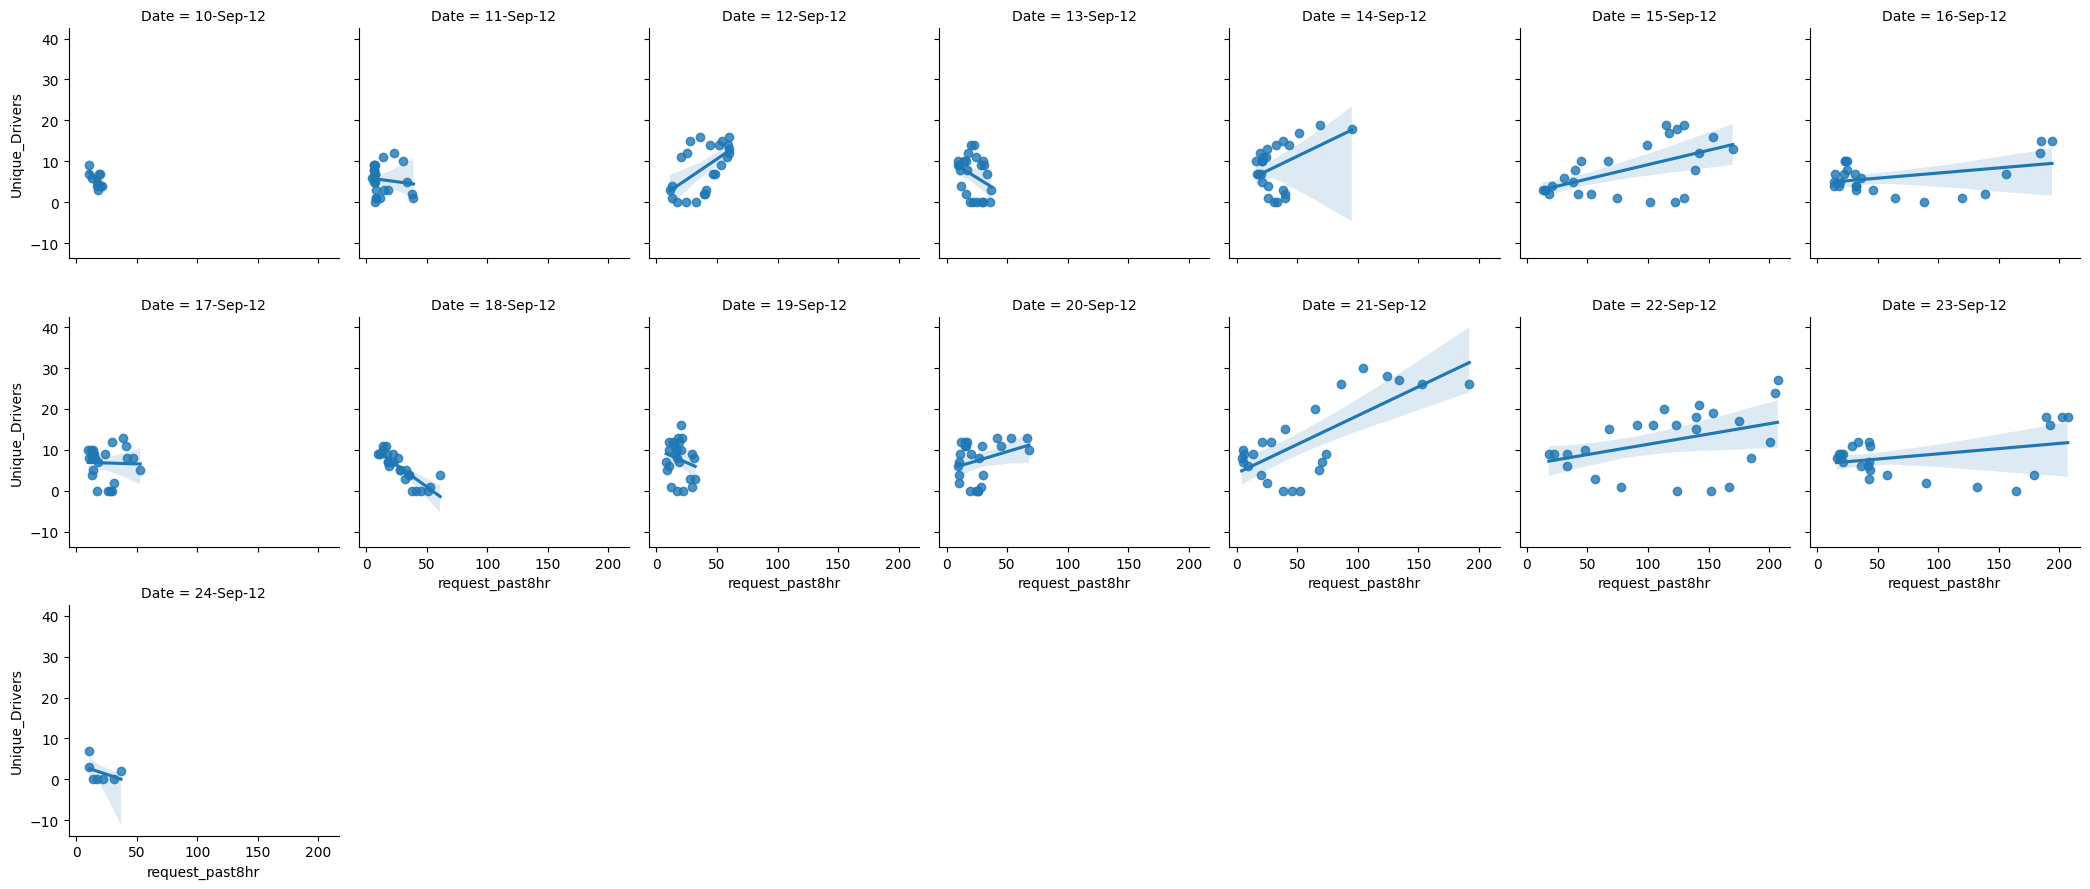

In [130]:
g = sns.FacetGrid(data=sd, col="Date", col_wrap=7)
g.map_dataframe(sns.regplot, x="request_past8hr", y="Unique_Drivers")

print(
    "While in most days, the driver supply increases when demand increases, it is not always true"
)

#### 8. In which 72 hour period is the ratio of Zeroes to Eyeballs the highest?

In [137]:
sd.nlargest(1, "zero_to_eye_p72")

,Date,Time,Eyeballs,Zeroes,Completed_Trips,Requests,Unique_Drivers,Weekday,Weekend,request_past8hr,test,zeroes_past72hr,eyeballs_past72hr,zero_to_eye_p72
189,18-Sep-12,4,1,1,0,0,0,1,0,41.0,3.0,438.0,1495.0,0.292977


#### 9. If you could add 5 drivers to any single hour of every day during the two week period, which hour should you add them to? Hint: Consider both rider eyeballs and driver supply when choosing

In [146]:
sd.groupby("Time", as_index=False).agg(
    eyeballs=("Eyeballs", "sum"), unique_drivers=("Unique_Drivers", "sum")
).assign(eye_to_driver=lambda x: x.eyeballs / x.unique_drivers).nlargest(
    1, "eye_to_driver"
)

,Time,eyeballs,unique_drivers,eye_to_driver
23,23,488,119,4.10084


#### 10.True or False: There is exactly two weeks of data in this analysis

In [159]:
print(sd.datets.max())
print(sd.datets.min())
print("No, there are 15 days in total")

2012-09-24 00:00:00
2012-09-10 00:00:00
No, there are 15 days in total
